# Kenali Sapinya
Anda memiliki 2 jenis gambar yaitu sapi tanpa background dan sapi dengan background.
Buatlah model pola sapi dengan gambar tanpa background. Kemudian gunakan pola tersebut untuk mendeteksi sapi dengan background. Gunakan interpolasi dan finite difference atau metode lain di dalam materi metode numerik.

Note:
1. Tidak boleh menggunakan library kecuali untuk membaca image
2. Algoritma Anda rancang sendiri dan implementasikan sendiri from scratch
3. Satu kelompok terdiri dari 4 orang.

## 

In [3]:
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time

# Read Images

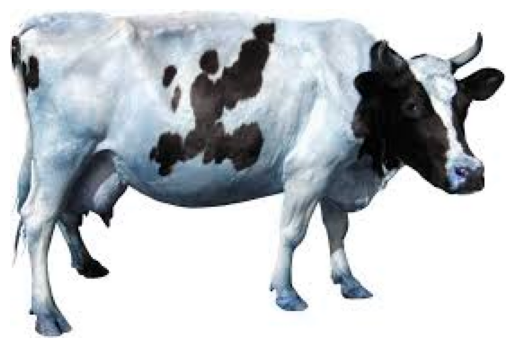

In [4]:
sapi_train_1 = cv2.imread('sapi1.jpg')
sapi_train_2 = cv2.imread('sapi2.jpeg')
sapi_train_3 = cv2.imread('sapi3.jpg')
plt.axis('off')
plt.imshow(sapi_train_2)

## Display Multiple Images

In [5]:
def display_side_by_side(images, labels, title):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(labels[i])
        
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


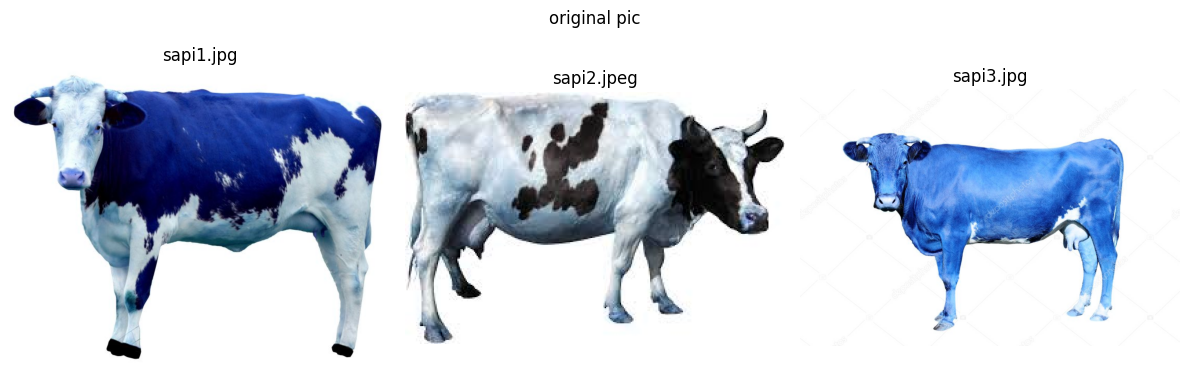

In [6]:
images = [sapi_train_1,sapi_train_2,sapi_train_3]
labels = ['sapi1.jpg', 'sapi2.jpeg', 'sapi3.jpg']

display_side_by_side(images, labels, title='original pic')

## Convert To Grayscale

In [7]:
def convert_to_grayscale(image):
    height = len(image)
    width = len(image[0])

    # Create a new matrix for the grayscale image
    grayscale_image = [[0] * width for _ in range(height)]

    # Iterate over each pixel
    for i in range(height):
        for j in range(width):
            # Calculate grayscale value using luminance conversion formula
            r, g, b = image[i][j]
            grayscale_value = int(0.2989 * r + 0.5870 * g + 0.1140 * b)
            # Set the grayscale value for all RGB channels
            grayscale_image[i][j] = grayscale_value

    return grayscale_image


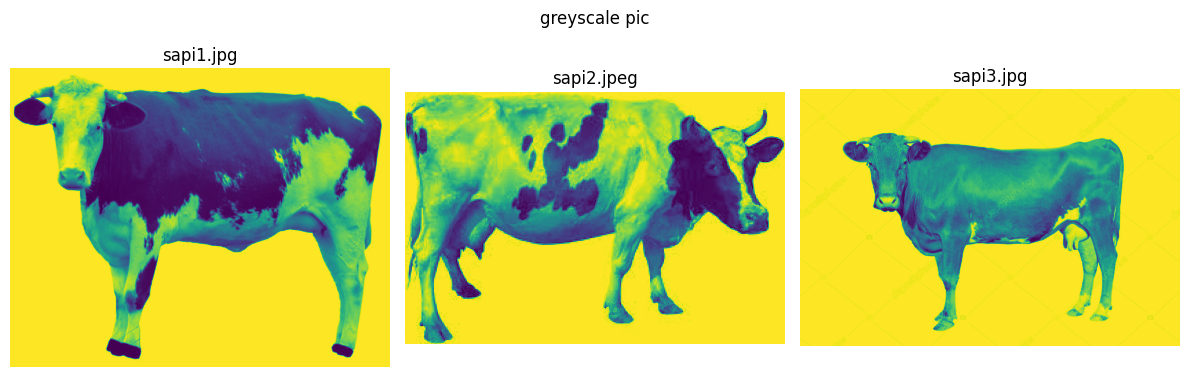

In [8]:
sapi_train_1 = convert_to_grayscale(sapi_train_1)
sapi_train_2 = convert_to_grayscale(sapi_train_2)
sapi_train_3 = convert_to_grayscale(sapi_train_3)

images = [sapi_train_1,sapi_train_2,sapi_train_3]
labels = ['sapi1.jpg', 'sapi2.jpeg', 'sapi3.jpg']

display_side_by_side(images, labels, title='greyscale pic')

## Edge detection with central difference

In [9]:
def get_shape(image):
    # assumes that array is symmetric
    return len(image), len(image[0])

def edge_detection(image, thres_high, thres_low):
    height, width = get_shape(image)

    # Initialize the edges image with zeros
    edges = [[0] * width for _ in range(height)]

    # Central difference kernel in the x-direction
    dx = [[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]]

    # Central difference kernel in the y-direction
    dy = [[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]]

    # Iterate over each pixel in the image
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Compute the gradient in the x-direction
            gradient_x = sum(dx[k][l] * image[i + k - 1][j + l - 1] for k in range(3) for l in range(3))

            # Compute the gradient in the y-direction
            gradient_y = sum(dy[k][l] * image[i + k - 1][j + l - 1] for k in range(3) for l in range(3))

            # Compute the magnitude of the gradient using approximation
            magnitude = (gradient_x ** 2 + gradient_y ** 2) ** 0.5

            # Apply double thresholding and set the corresponding pixel in the edges image
            if magnitude > thres_high:
                edges[i][j] = 255
            elif magnitude > thres_low:
                edges[i][j] = 128

    return edges

In [10]:
def display_image(image):
    height = len(image)
    width = len(image[0])
    
    # Create x and y coordinates for each pixel
    x_coords = [[x]*width for x in range(height)]
    y_coords = [list(range(width)) for _ in range(height)]
    
    # Flatten the image and coordinates into 1D lists
    pixel_values = [pixel for row in image for pixel in row]
    x_coords = [coord for row in x_coords for coord in row]
    y_coords = [coord for row in y_coords[::-1] for coord in row]  # Reverse the y-coordinates
    
    # Display the image using pyplot
    # plt.figure(figsize=(width/80, height/80))  # Adjust the figure size if needed
    plt.scatter(y_coords, x_coords, c=pixel_values, marker='s', s=20)
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.axis('off')
    plt.show()


## Display Edges of Sapi 1, 2, 3

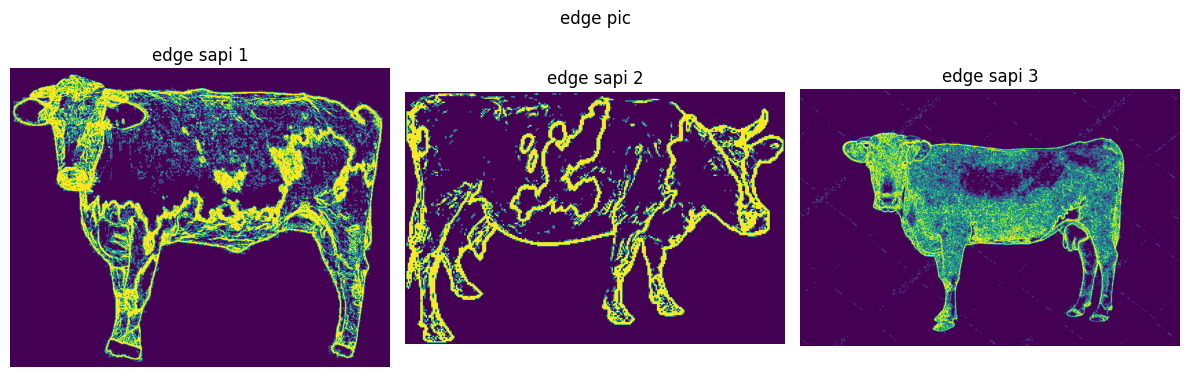

In [11]:
edge_sapi_1 = edge_detection(sapi_train_1, thres_high=5, thres_low=3)
edge_sapi_2 = edge_detection(sapi_train_2, thres_high=19, thres_low=15)
edge_sapi_3 = edge_detection(sapi_train_3, thres_high=15, thres_low=7)

images = [edge_sapi_1, edge_sapi_2, edge_sapi_3]
labels = ['edge sapi 1', 'edge sapi 2', 'edge sapi 3']

display_side_by_side(images, labels, title='edge pic')


The green lines indicate areas with lower intensity values, while the yellow lines indicate areas with higher intensity values.

## Connect Disjointed Edges

### Horizontal Connect

In [12]:
def connect_edges_horizontal(edges, connect_interval, start_row, end_row, horizontal_join):
    height = len(edges)
    width = len(edges[0])

    # Adjust start and end row within the image boundaries
    start_row = max(start_row, 0)
    end_row = min(end_row, height - 1)

    # Calculate the additional pixels to join horizontally
    join_pixels =  horizontal_join + 1

    # Iterate over each row in the specified area
    for i in range(start_row, end_row + 1):
        # Flag to indicate if the previous pixel is an edge point
        prev_edge = False

        # Initialize the starting and ending x-coordinates
        start_x = None
        end_x = None

        # Retrieve the processed maximum x and minimum x values for the current row
        row_min_x = min([j for j in range(width) if edges[i][j] > 0], default=None)
        row_max_x = max([j for j in range(width) if edges[i][j] > 0], default=None)

        # Iterate over each pixel in the row
        for j in range(width):
            # Check if the current pixel is an edge point
            if edges[i][j] > 0:
                # If the previous pixel was not an edge point, start a new edge segment
                if not prev_edge:
                    prev_edge = True
                    start_x = j
                # If the previous pixel was an edge point, update the ending x-coordinate
                end_x = j
            # If the current pixel is not an edge point and the previous pixel was an edge point,
            # interpolate the edge segment between the two points within the specified connect interval
            elif prev_edge:
                prev_edge = False

                # Perform non-linear interpolation between the start and end points (skip when start and end points are the same)
                if start_x != end_x:
                    for k in range(start_x, end_x + 1):
                        for l in range(i - connect_interval, i + connect_interval + 1):
                            if l >= 0 and l < height:
                                # Calculate the interpolation weight
                                weight = abs(k - (start_x + end_x) / 2) / (end_x - start_x)

                                # Apply non-linear interpolation using the weight
                                interpolated_intensity = int(
                                    (1 - weight) * edges[l][start_x] + weight * edges[l][end_x])

                                # Update the pixel intensity with the interpolated value,
                                # considering the neighboring pixels as well
                                for m in range(max(k - horizontal_join, row_min_x),
                                               min(k + horizontal_join + 1, row_max_x + 1)):
                                    # Increase the connection strength by adjusting the interpolated intensity
                                    # with a larger weight towards the neighboring pixel intensities
                                    edges[l][m] = max(
                                        int((interpolated_intensity * 0.65) + (edges[l][m] * 0.35)),
                                        edges[l][m]
                                    )

    return edges


### Perform Connection Disjointed Edge

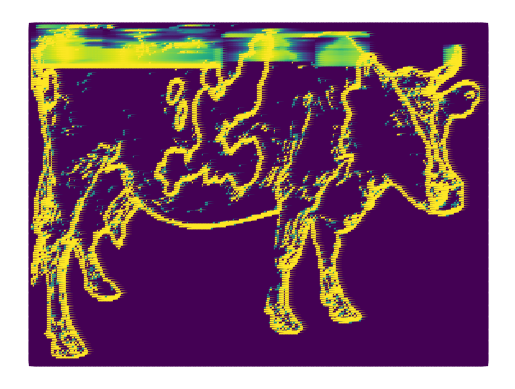

In [13]:
# sapi_not_connected = edge_sapi_2.copy
connected_edges = connect_edges_horizontal(edge_sapi_2, connect_interval = 9,start_row=5, end_row=15, horizontal_join=2)
# images = [sapi_not_connected, connected_edges]
# labels = ['sapi 2 before interpolated', 'sapi 2 after interpolated']
display_image(connected_edges)
# display_side_by_side_modified(images, labels, title='connect upper edges')

In [14]:
def add_padding(image, padding_size):
    height = len(image)
    width = len(image[0])

    # Calculate the new dimensions
    padded_height = height + (2 * padding_size)
    padded_width = width + (2 * padding_size)

    # Create a new image with the padded dimensions
    padded_image = [[0] * padded_width for _ in range(padded_height)]

    # Copy the original image to the center of the padded image
    for i in range(height):
        for j in range(width):
            padded_image[i + padding_size][j + padding_size] = image[i][j]

    return padded_image

padded = add_padding(connected_edges, 20)

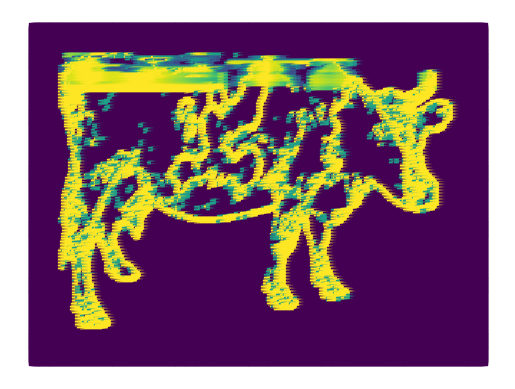

In [15]:
def apply_edge_bleeding(image, threshold, border_width, bleed_intensity):
    height = len(image)
    width = len(image[0])

    # Create a blank image to store the result
    result = [[0] * width for _ in range(height)]

    # Iterate over each pixel in the image
    for i in range(height):
        for j in range(width):
            # Check if the pixel is an edge point
            if image[i][j] > threshold:
                # Apply yellow border to edge pixels
                if i < border_width or i >= height - border_width or j < border_width or j >= width - border_width:
                    result[i][j] = 255  # Set intensity to maximum (yellow)
                else:
                    # Spread intensity in the surrounding area using shades of green
                    intensity = image[i][j]
                    for k in range(-border_width, border_width + 1):
                        for l in range(-border_width, border_width + 1):
                            result[i+k][j+l] = min(intensity + bleed_intensity, 255)  # Increase intensity

    return result

bleeded = apply_edge_bleeding(padded, 40, 1, 15)
display_image(bleeded)

In [16]:
def crop_edges(edges, top_crop, bottom_crop, left_crop, right_crop):
    height = len(edges)
    width = len(edges[0])

    # Calculate the crop boundaries
    top = top_crop
    bottom = height - bottom_crop
    left = left_crop
    right = width - right_crop

    # Crop the edges image based on the boundaries
    cropped_edges = [row[left:right] for row in edges[top:bottom]]

    return cropped_edges

cropped_sapi_3 = crop_edges(edge_sapi_3, 100, 20, 110, 110)

## Display all edge refined pics

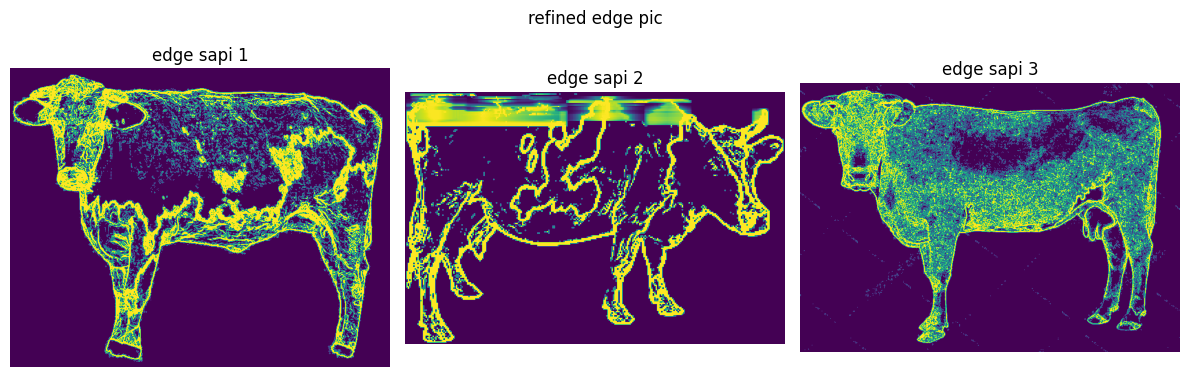

In [17]:
images = [edge_sapi_1, edge_sapi_2, cropped_sapi_3]
labels = ['edge sapi 1', 'edge sapi 2', 'edge sapi 3']  

display_side_by_side(images, labels, title='refined edge pic')


# Read sapi_x as test data

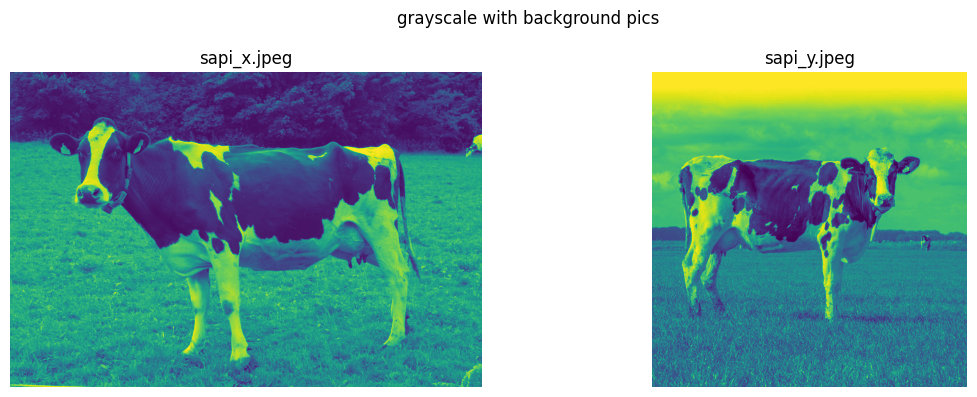

In [50]:
sapi_test = cv2.imread('sapi_x.jpeg')
sapi_test_2 = cv2.imread('sapiy.jpg')
sapi_test_gray = convert_to_grayscale(sapi_test)
sapi_test_gray_2 = convert_to_grayscale(sapi_test_2)


images = [sapi_test_gray, sapi_test_gray_2]
labels = ['sapi_x.jpeg','sapi_y.jpeg']

display_side_by_side(images, labels, title='grayscale with background pics')

## Blur image with Gaussian Blur

Untuk meringankan beban komputasi, kita blur gambarnya

In [35]:
def gaussian_blur(image, blur_strength):
    height, width = len(image), len(image[0])
    kernel_size = blur_strength * 2 + 1

    # Create the 1D Gaussian kernel
    kernel_1d = [0] * kernel_size
    kernel_sum = 0

    # Calculate the 1D Gaussian kernel using the Binomial coefficient approximation
    for i in range(kernel_size):
        x = i - blur_strength
        value = 1 / (2 ** abs(x))
        kernel_1d[i] = value
        kernel_sum += value

    # Normalize the kernel
    kernel_1d = [value / kernel_sum for value in kernel_1d]

    blurred_image = [[0] * width for _ in range(height)]

    # Apply the horizontal pass
    for i in range(height):
        for j in range(width):
            pixel_sum = 0

            for k in range(kernel_size):
                x = j + k - blur_strength
                if 0 <= x < width:
                    pixel_sum += image[i][x] * kernel_1d[k]

            blurred_image[i][j] = int(pixel_sum)

    # Apply the vertical pass
    for j in range(width):
        for i in range(height):
            pixel_sum = 0

            for k in range(kernel_size):
                y = i + k - blur_strength
                if 0 <= y < height:
                    pixel_sum += blurred_image[y][j] * kernel_1d[k]

            blurred_image[i][j] = int(pixel_sum)

    return blurred_image


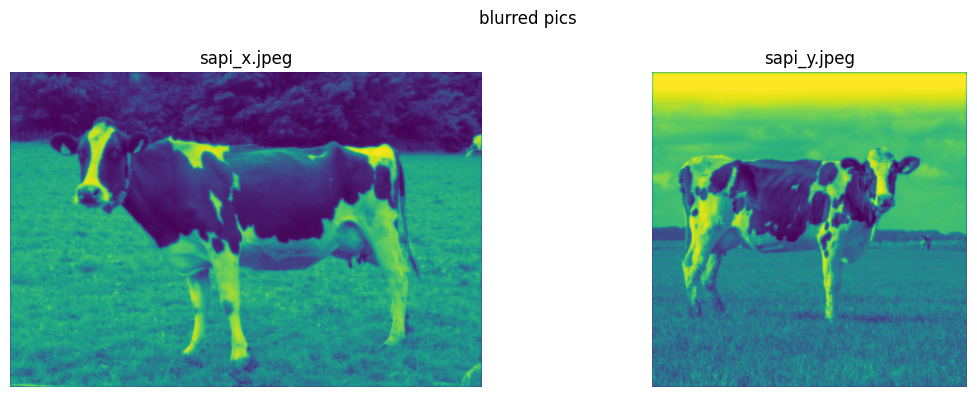

In [51]:
# Example usage
blurred_image1 = gaussian_blur(sapi_test_gray, blur_strength=60)
blurred_image2 = gaussian_blur(sapi_test_gray_2, blur_strength=70)


images = [blurred_image1, blurred_image2]
labels = ['sapi_x.jpeg','sapi_y.jpeg']

display_side_by_side(images, labels, title='blurred pics')

## Edge detection sapi with background

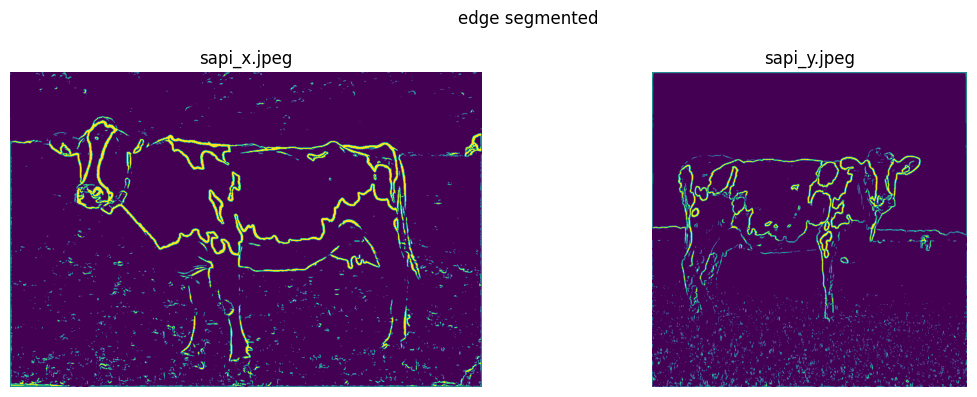

In [53]:
blur_copy1 = blurred_image1.copy()
blur_copy2 = blurred_image2.copy()
edge_sapi_test = edge_detection(blur_copy1, thres_high=12, thres_low=10)
edge_sapi_test2 = edge_detection(blur_copy2, thres_high=16, thres_low=12)

images = [edge_sapi_test, edge_sapi_test2]
labels = ['sapi_x.jpeg','sapi_y.jpeg']

display_side_by_side(images, labels, title='edge segmented')